In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# 1. Preparazione del Dataset:

###    - Caricamento e preprocessamento dei dati sui prezzi immobiliari.


In [4]:
# import direttamente dall'url
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv'
df_house = pd.read_csv(url)
print("n_sample: "+str(len(df_house)))
print("\n")
print(df_house.head())

n_sample: 545


      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus  
0                 1  
1                 1  
2                 2  
3                 1  
4                 1  


#### Abbiamo una feature continua, 4 feature categoriche, 1 feature nominale e  6 feature binarie

#### Andiamo a cercare eventuali dati mancanti nel dataset

In [6]:
# ricerca di eventuali colonne con dati mancanti
nan_counts = df_house.isna().sum()
print(nan_counts)

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


#### *non ci sono colonne con dati mancanti*

#### La feature "furnishingstatus", che è nominale, viene trasformata con la tecnica one hot encoding

In [9]:
df_house = pd.get_dummies(df_house, columns=['furnishingstatus'])
df_house = df_house.astype(int)
print(df_house.head())

      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus_0  furnishingstatus_1  furnishingstatus_2  
0                   0                   1                   0  
1                   0         

# 2. Implementazione dei Modelli di Regressione e 3. Valutazione delle Performance

In [11]:
X = df_house.drop(columns=['price'])
y = df_house['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Standardizzazione 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creiamo un dizionario con dei sottodizionari, uno per ogni modello, che contengano il modello stesso e tutti i vari metadati
modelli = dict()
# Modello Ridge
modelli["Ridge"] = dict()
modelli["Ridge"]["modello"] = Ridge()
modelli["Ridge"]["iperparametri"] = {"alpha": np.logspace(-3, 2, 100)}

# Modello Lasso
modelli["Lasso"] = dict()
modelli["Lasso"]["modello"] = Lasso()
modelli["Lasso"]["iperparametri"] = {"alpha": np.logspace(-3, 2, 100)}

# Modello ElasticNet
modelli["ElasticNet"] = dict()
modelli["ElasticNet"]["modello"] = ElasticNet()
modelli["ElasticNet"]["iperparametri"] = {"alpha": np.logspace(-3, 2, 100), 'l1_ratio': np.linspace(0, 1, 50)}


In [12]:
# funzione che prende in input un modello e i suoi iperparametri e lo addestra con una 5 fold CV, salvando i risultati ottenuti ed il modello tunato
def ottimizza_modello(modello, iperparametri):
    grid_search = GridSearchCV(estimator=modello, param_grid=iperparametri, 
                           scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

    grid_search.fit(X_train_scaled, y_train)
    
    best_params = grid_search.best_params_
    print(best_params)
    best_score = -grid_search.best_score_
    print(best_score)
    best_model = grid_search.best_estimator_

    return best_model, best_score
 

In [13]:

for nome_modello in modelli.keys():
    print("------- "+nome_modello+" --------")
    modelli[nome_modello]["modello_tunato"], modelli[nome_modello]["mae"] = ottimizza_modello(modelli[nome_modello]["modello"],
                                                                                              modelli[nome_modello]["iperparametri"])
    # coefficienti non nulli
    coefs = modelli[nome_modello]["modello_tunato"].coef_
    non_zero_coefs = np.sum(coefs != 0)
    modelli[nome_modello]["coefficienti"] = coefs
    print(f'{nome_modello} - Numero di coefficienti non nulli: {non_zero_coefs}')
    print("\n")


------- Ridge --------
{'alpha': 89.02150854450393}
739972.3740487794
Ridge - Numero di coefficienti non nulli: 14


------- Lasso --------
{'alpha': 100.0}
748412.7458657483
Lasso - Numero di coefficienti non nulli: 13


------- ElasticNet --------
{'alpha': 0.5336699231206307, 'l1_ratio': 0.5102040816326531}
739935.538059179
ElasticNet - Numero di coefficienti non nulli: 14




#### I 3 modelli hanno circa lo stesso numero di coefficienti non nulli

# 4. Visualizzazione dei Risultati

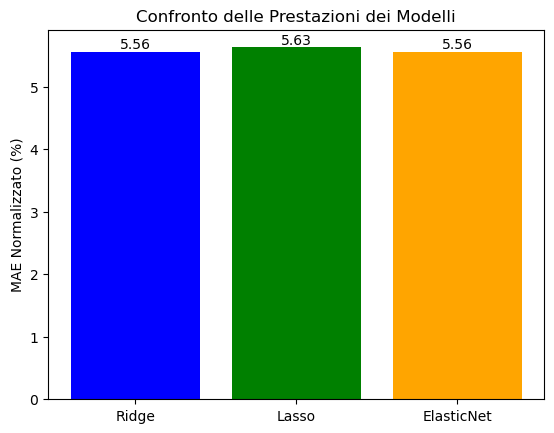

In [16]:
models = list()
mae_values = list()
for nome_modello in modelli.keys():
    models.append(nome_modello)
    mae_values.append(round(modelli[nome_modello]["mae"]/max(df_house["price"])*100, 2))
bars = plt.bar(models, mae_values, color=['blue', 'green', 'orange'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')
plt.ylabel('MAE Normalizzato (%)')
plt.title('Confronto delle Prestazioni dei Modelli')
plt.show()

#### I 3 modelli hanno performance molto simili

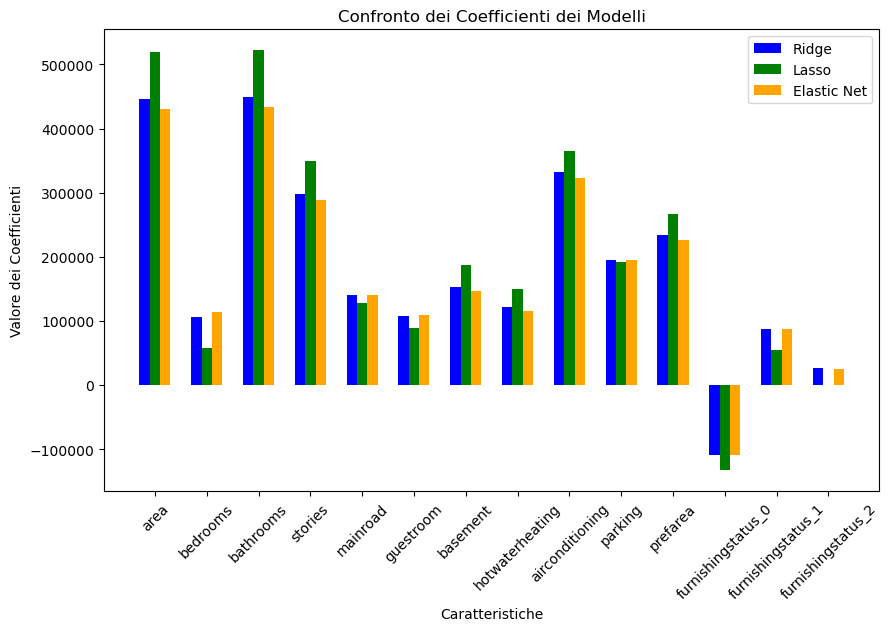

In [18]:
feature_names = X.columns
x = np.arange(len(feature_names))
width = 0.2 

# Crea il grafico a barre raggruppate
plt.figure(figsize=(10, 6))
plt.bar(x - width, modelli["Ridge"]["coefficienti"], width, label='Ridge', color='blue')
plt.bar(x, modelli["Lasso"]["coefficienti"], width, label='Lasso', color='green')
plt.bar(x + width, modelli["ElasticNet"]["coefficienti"], width, label='Elastic Net', color='orange')

plt.xlabel('Caratteristiche')
plt.ylabel('Valore dei Coefficienti')
plt.title('Confronto dei Coefficienti dei Modelli')
plt.xticks(x, feature_names, rotation=45) 
plt.legend()

plt.show()

#### Le feature con maggior impatto sulle previsioni, per tutti e 3 i modelli, sembrano essere: area, bathrooms e airconditioning

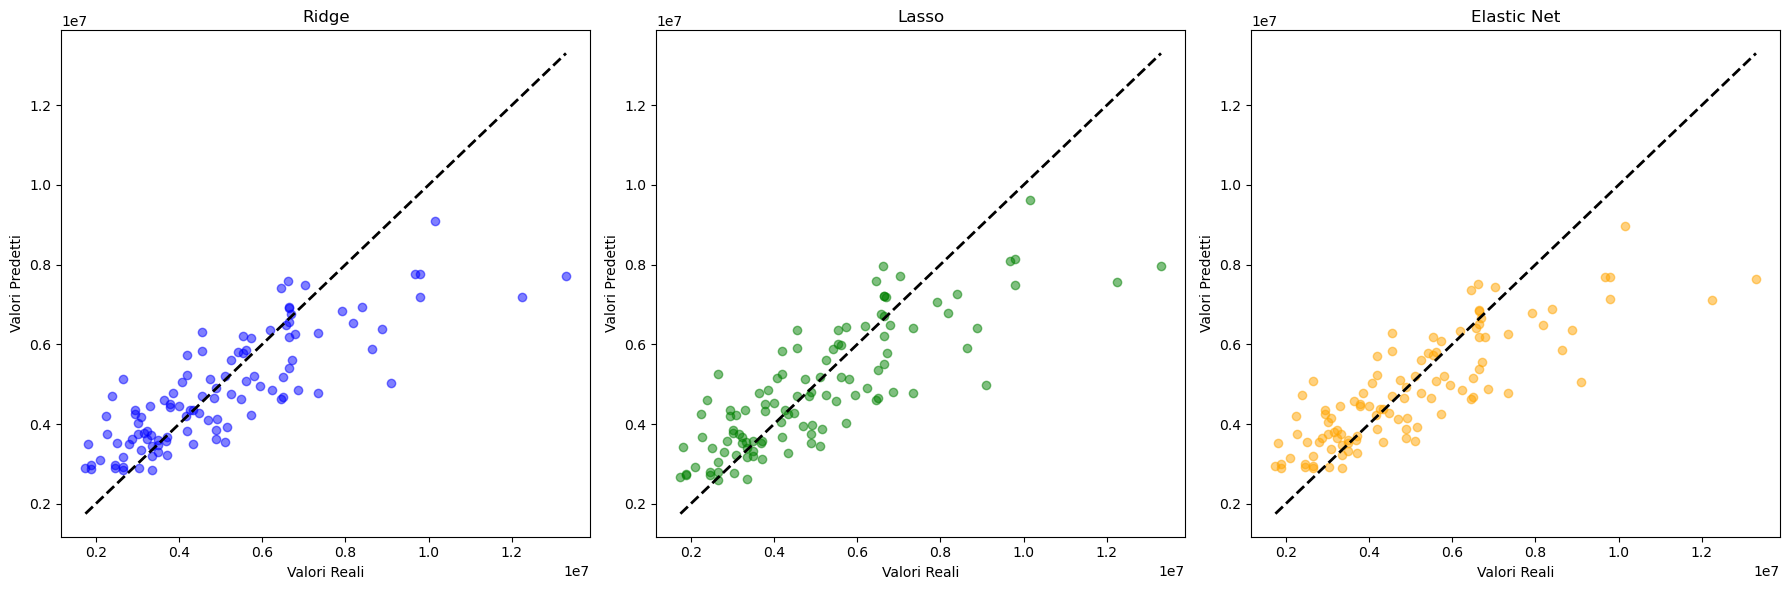

In [20]:
y_true = y_test.to_numpy()
y_pred_ridge = modelli["Ridge"]["modello_tunato"].predict(X_test_scaled)
y_pred_lasso = modelli["Lasso"]["modello_tunato"].predict(X_test_scaled)
y_pred_elasticnet = modelli["ElasticNet"]["modello_tunato"].predict(X_test_scaled)

# Creiamo una figura con tre subplot affiancati
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Grafico di parità per Ridge
axs[0].scatter(y_true, y_pred_ridge, alpha=0.5, color='blue')
axs[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
axs[0].set_xlabel('Valori Reali')
axs[0].set_ylabel('Valori Predetti')
axs[0].set_title('Ridge')

# Grafico di parità per Lasso
axs[1].scatter(y_true, y_pred_lasso, alpha=0.5, color='green')
axs[1].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
axs[1].set_xlabel('Valori Reali')
axs[1].set_ylabel('Valori Predetti')
axs[1].set_title('Lasso')

# Grafico di parità per Elastic Net
axs[2].scatter(y_true, y_pred_elasticnet, alpha=0.5, color='orange')
axs[2].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
axs[2].set_xlabel('Valori Reali')
axs[2].set_ylabel('Valori Predetti')
axs[2].set_title('Elastic Net')

# Per evitare sovrapposizioni
plt.tight_layout()
plt.show()

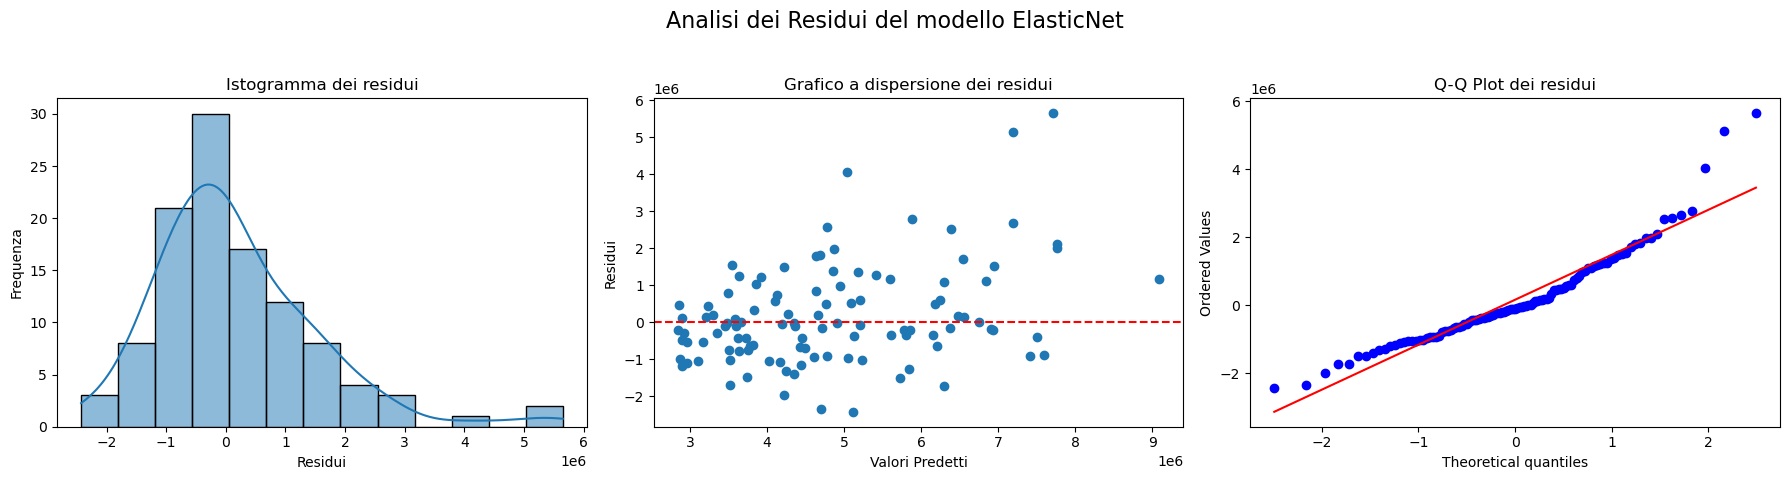

In [26]:
# Calcola i residui
residuals = y_test - y_pred_elasticnet

# Crea la figura con sottotrame
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Analisi dei Residui del modello ElasticNet', fontsize=16)

# Istogramma dei residui
sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title('Istogramma dei residui')
axes[0].set_xlabel('Residui')
axes[0].set_ylabel('Frequenza')

# Grafico a dispersione dei residui
axes[1].scatter(y_pred_ridge, residuals)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Grafico a dispersione dei residui')
axes[1].set_xlabel('Valori Predetti')
axes[1].set_ylabel('Residui')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot dei residui')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Aggiusta il layout per includere il titolo principale
plt.show()

#### Gli errori più importanti sul test set avvengono sulle case con il presso più alto

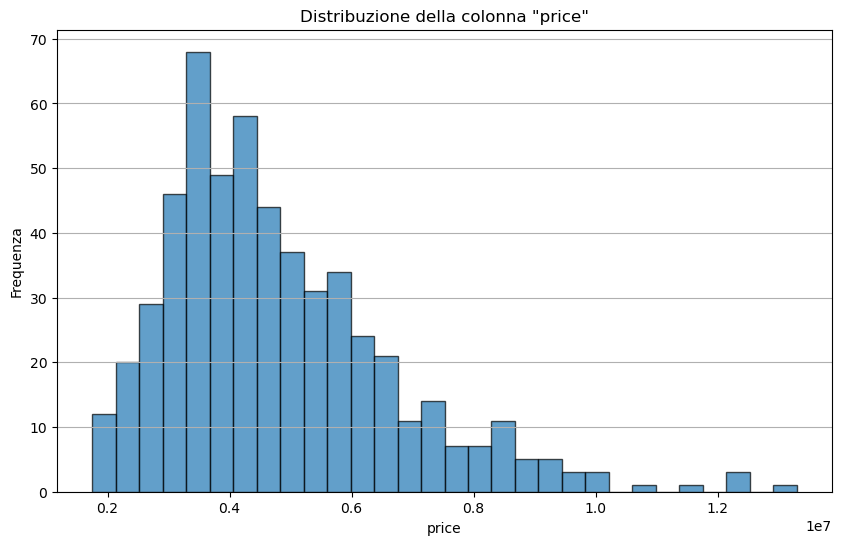

In [33]:
# Crea un istogramma della distribuzione
plt.figure(figsize=(10, 6))
plt.hist(df_house["price"], bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Distribuzione della colonna "price"')
plt.xlabel("price")
plt.ylabel('Frequenza')
plt.grid(axis='y')
plt.show()

#### In effetti, osservando la distribuzione della colonna "price", ci sono relativamente pochi dati sui prezzi molto alti. Sicuramente sarebbe utile collezionare altri dati per quella fascia di prezzo

#### 

#### Cerchiamo di studiare l'andamento dei coefficienti rispetto ai parametri di regolarizzazione per uno dei 3 modelli, visto che hanno comportamenti simili. Prendiamo come esempio il modello Ridge

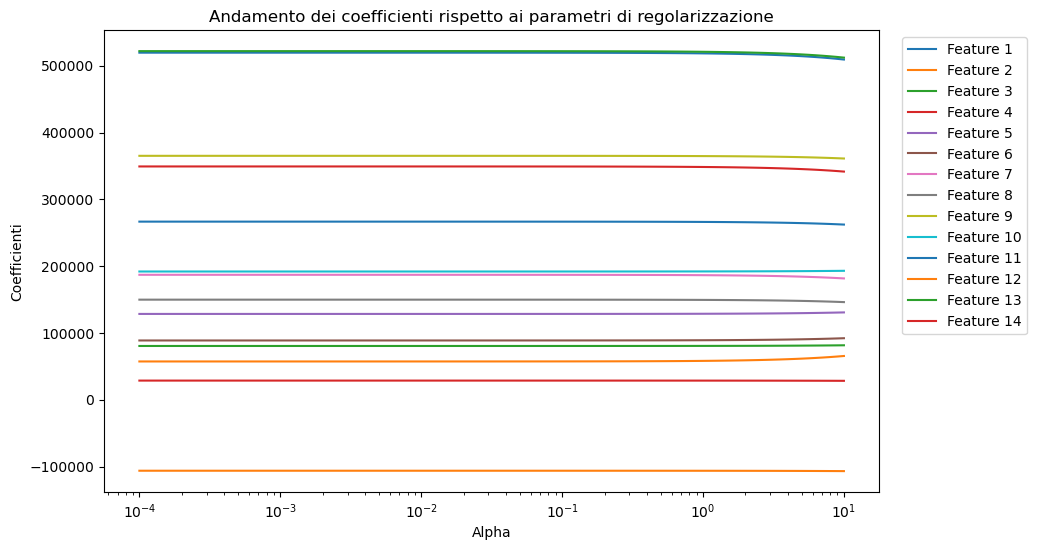

In [43]:
alphas = np.logspace(-4, 1, 100)

# Lista per conservare i coefficienti
coefs = []

# Calcola i coefficienti per ciascun valore di alpha
for alpha in alphas:
    lasso = Ridge(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

# Converte la lista dei coefficienti in un array numpy
coefs = np.array(coefs)

# Visualizza l'andamento dei coefficienti
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], label=f'Feature {i+1}')

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficienti')
plt.title('Andamento dei coefficienti rispetto ai parametri di regolarizzazione')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

#### I coeffienti dei predittori sono stabili rispetto alle variazioni del parametro alpha. Questo può significare che il modello non sta sovradattando i dati e che i predittori hanno un'influenza consistente sul risultato. Indicano quindi un modello robusto